In [1]:
from tensorflow.keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 

#Loads the VGG16 model 
vgg16 = VGG16(weights = 'imagenet', 
                include_top = False, 
                input_shape = (img_rows, img_cols, 3))

In [3]:
# Let's print our layers 
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer True
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


In [5]:
from tensorflow.keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 64
img_cols = 64 

# Re-loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                include_top = False, 
                input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg16.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [6]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model

num_classes = 36

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs=vgg16.input, outputs=FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'E:\Porject\Fruits and Vegetables TF\train'
validation_data_dir = r'E:\Porject\Fruits and Vegetables TF\validation'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    )

validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 10
val_batchsize = 16

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


In [11]:
train_generator.class_indices

{'apple': 0,
 'banana': 1,
 'beetroot': 2,
 'bell pepper': 3,
 'cabbage': 4,
 'capsicum': 5,
 'carrot': 6,
 'cauliflower': 7,
 'chilli pepper': 8,
 'corn': 9,
 'cucumber': 10,
 'eggplant': 11,
 'garlic': 12,
 'ginger': 13,
 'grapes': 14,
 'jalepeno': 15,
 'kiwi': 16,
 'lemon': 17,
 'lettuce': 18,
 'mango': 19,
 'onion': 20,
 'orange': 21,
 'paprika': 22,
 'pear': 23,
 'peas': 24,
 'pineapple': 25,
 'pomegranate': 26,
 'potato': 27,
 'raddish': 28,
 'soy beans': 29,
 'spinach': 30,
 'sweetcorn': 31,
 'sweetpotato': 32,
 'tomato': 33,
 'turnip': 34,
 'watermelon': 35}

In [13]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("intelimage.h5",
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                        min_delta = 0, 
                        patience = 3,
                        verbose = 1,
                        restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
            optimizer = RMSprop(learning_rate = 0.001),
            metrics = ['accuracy'])

nb_train_samples = 3115
nb_validation_samples = 351
epochs = 30
batch_size = 32

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)



Epoch 1/30
97/97 [==============================] - ETA: 0s - loss: 3.1330 - accuracy: 0.1575
Epoch 1: val_loss improved from inf to 2.57838, saving model to intelimage.h5
97/97 [==============================] - 41s 420ms/step - loss: 3.1330 - accuracy: 0.1575 - val_loss: 2.5784 - val_accuracy: 0.2750
Epoch 2/30
97/97 [==============================] - ETA: 0s - loss: 2.8471 - accuracy: 0.2278
Epoch 2: val_loss improved from 2.57838 to 2.13762, saving model to intelimage.h5
97/97 [==============================] - 46s 474ms/step - loss: 2.8471 - accuracy: 0.2278 - val_loss: 2.1376 - val_accuracy: 0.3938
Epoch 3/30
97/97 [==============================] - ETA: 0s - loss: 2.6709 - accuracy: 0.2598
Epoch 3: val_loss improved from 2.13762 to 1.91686, saving model to intelimage.h5
97/97 [==============================] - 46s 474ms/step - loss: 2.6709 - accuracy: 0.2598 - val_loss: 1.9169 - val_accuracy: 0.4875
Epoch 4/30
97/97 [==============================] - ETA: 0s - loss: 2.5743 - acc

In [16]:
# CLASSIFICATION REPORT AND THE CONFUSION MATRIX FOR THE vgg16
# Displaying our Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
class_labels = {0:'apple',
 1:'banana',
 2:'beetroot',
 3:'bell pepper',
 4:'cabbage',
 5:'capsicum',
 6:'carrot',
 7:'cauliflower',
 8:'chilli pepper',
 9:'corn',
 10:'cucumber',
 11:'eggplant',
 12:'garlic',
 13:'ginger',
 14:'grapes',
 15:'jalepeno',
 16:'kiwi',
 17:'lemon',
 18:'lettuce',
 19:'mango',
 20:'onion',
 21:'orange',
 22:'paprika',
 23:'pear',
 24:'peas',
 25:'pineapple',
 26:'pomegranate',
 27:'potato',
 28:'raddish',
 29:'soy beans',
 30:'spinach',
 31:'sweetcorn',
 32:'sweetpotato',
 33:'tomato',
 34:'turnip',
 35:'watermelon'}
#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples) # put classifier not model
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))



22/22 [==============================] - 13s 583ms/step
Confusion Matrix
[[5 0 0 ... 2 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 1 ... 0 2 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 6]]
Classification Report
               precision    recall  f1-score   support

        apple       0.62      0.50      0.56        10
       banana       1.00      0.89      0.94         9
     beetroot       0.33      0.10      0.15        10
  bell pepper       0.57      0.89      0.70         9
      cabbage       0.82      0.90      0.86        10
     capsicum       0.71      0.50      0.59        10
       carrot       0.58      0.78      0.67         9
  cauliflower       0.83      1.00      0.91        10
chilli pepper       0.43      0.67      0.52         9
         corn       0.78      0.70      0.74        10
     cucumber       0.83      1.00      0.91        10
     eggplant       0.47      0.80      0.59        10
       garlic       0.91      1.00      0.95        10
       ginger 

22/22 [==============================] - 13s 591ms/step


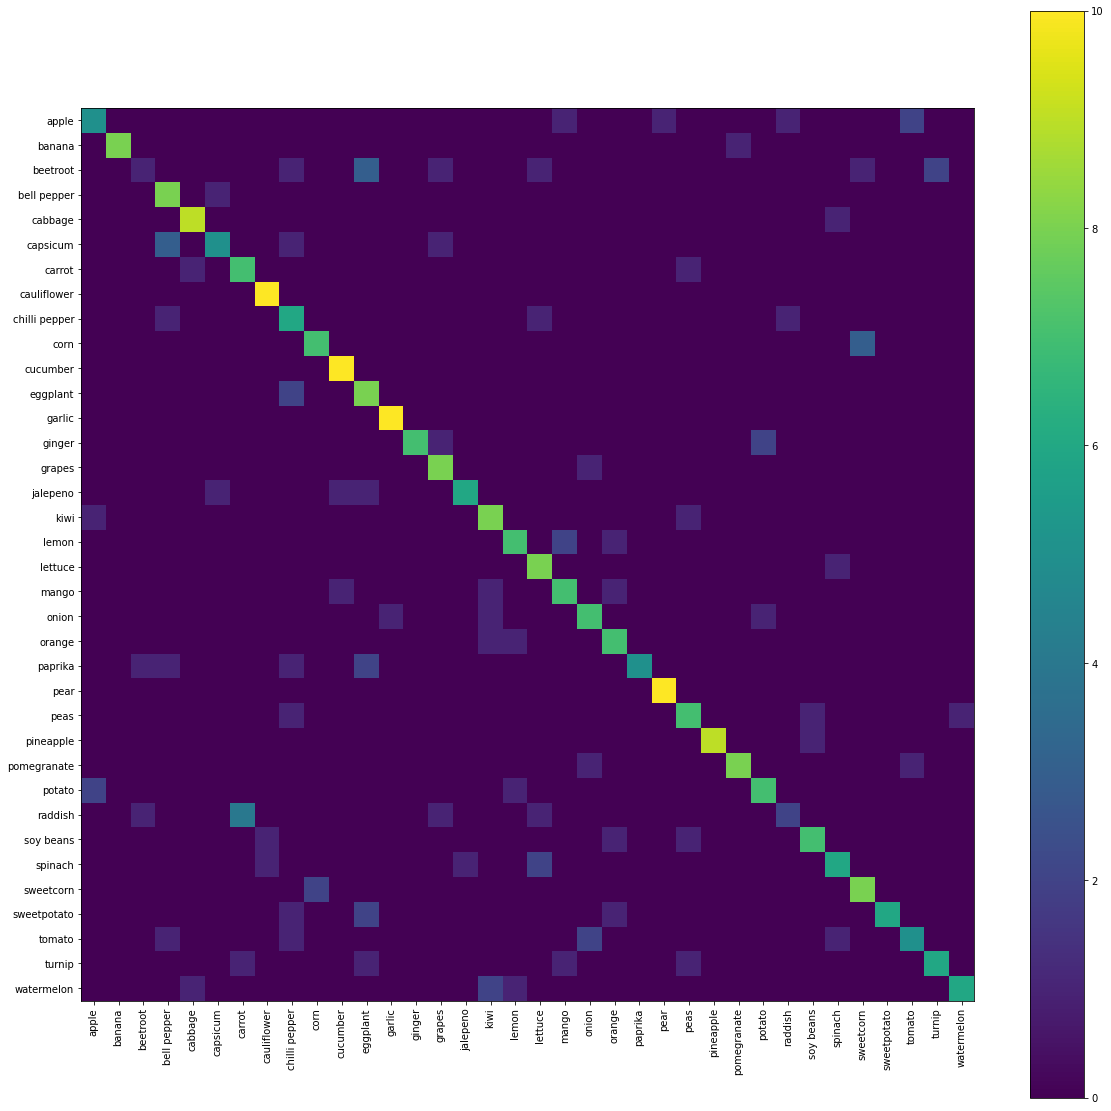

In [17]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 224,224,3
model = load_model('E:\Porject\Fruits and Vegetables TF\intelimage.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 14034
nb_validation_samples = 3000

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

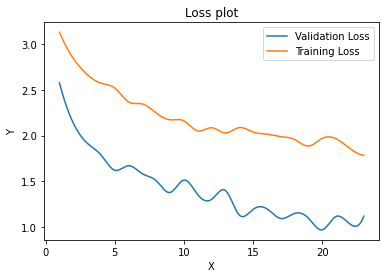

In [18]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt 
history_dict = history.history
loss_values = history_dict['loss']
n = len(loss_values)
epochs = range(1, len(loss_values) + 1)
y=history_dict['loss']
y1=history_dict['val_loss']

model = make_interp_spline(epochs, y)
model1 = make_interp_spline(epochs, y1)
xs=np.linspace(1,n,500)
ys=model(xs)
ys1 = model1(xs)

plt.xlabel('Epochs') 
plt.plot(xs, ys1, label='Validation Loss')
plt.plot(xs, ys,label='Training Loss')
plt.title("Loss plot")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

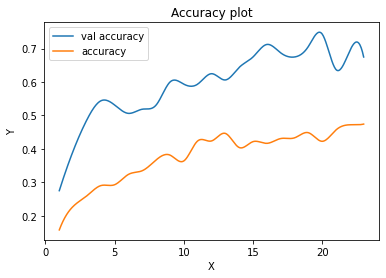

In [19]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt 
history_dict = history.history
loss_values = history_dict['loss']
n = len(loss_values)
epochs = range(1, len(loss_values) + 1)
y=history_dict['accuracy']
y1=history_dict['val_accuracy']

model=make_interp_spline(epochs, y)
model1=make_interp_spline(epochs, y1)
xs=np.linspace(1,n,500)
ys=model(xs)
ys1 = model1(xs)
plt.xlabel('Epochs') 
plt.plot(xs, ys1, label='val accuracy')
plt.plot(xs, ys,label='accuracy')
plt.title("Accuracy plot")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds_keras = roc_curve(validation_generator.classes, y_pred)

plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
epochs = range(1, len(loss_values) + 1)
model=make_interp_spline(epochs, y)

xs=np.linspace(1,len(epochs),500)
ys=model(xs)
roc_auc_score = roc_auc_score(validation_generator.classes, y_pred)
plt.plot(xs,ys,label='ROC (area = {:.3f})'.format(roc_auc_score))
plt.title('ROC curve')
plt.legend(loc='best')
# plt.plot(xs, ys, label='val accuracy')
plt.show()

ValueError: multiclass format is not supported

In [21]:
history.history

{'loss': [3.1330292224884033,
  2.847095489501953,
  2.6709108352661133,
  2.574328899383545,
  2.5213310718536377,
  2.368933916091919,
  2.3460938930511475,
  2.2460103034973145,
  2.172844648361206,
  2.1610217094421387,
  2.0506398677825928,
  2.0851938724517822,
  2.0279109477996826,
  2.0869126319885254,
  2.03753924369812,
  2.015957832336426,
  1.9878827333450317,
  1.956229329109192,
  1.8841629028320312,
  1.9688395261764526,
  1.9641587734222412,
  1.8581613302230835,
  1.7852213382720947],
 'accuracy': [0.15751294791698456,
  0.2278350442647934,
  0.25979381799697876,
  0.29015544056892395,
  0.2927834987640381,
  0.3237113356590271,
  0.3347150385379791,
  0.36701029539108276,
  0.3814432919025421,
  0.3639175295829773,
  0.4237113296985626,
  0.4237113296985626,
  0.446391761302948,
  0.40414509177207947,
  0.4216494858264923,
  0.41658031940460205,
  0.4309278428554535,
  0.4329896867275238,
  0.4484536051750183,
  0.42268040776252747,
  0.45670104026794434,
  0.47216495

1/1 [==============================] - 0s 153ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 5.2604574e-01 0.0000000e+00
  1.3554822e-25 0.0000000e+00 0.0000000e+00 1.0465173e-09 0.0000000e+00
  0.0000000e+00 1.6534344e-15 0.0000000e+00 0.0000000e+00 0.0000000e+00
  5.3782503e-07 0.0000000e+00 0.0000000e+00 1.1612935e-28 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.7395366e-01
  0.0000000e+00 0.0000000e+00 0.0000000e+00 8.8961589e-32 0.0000000e+00
  1.0948546e-33 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.9501064e-21
  0.0000000e+00]]


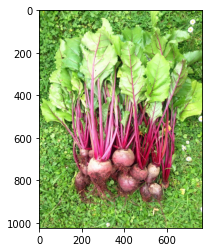

In [23]:
#Testing the models
import tensorflow
import keras
import numpy as np
# from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
 
# creating a object
model = keras.models.load_model('E:\Porject\Fruits and Vegetables TF\intelimage.h5')

path = r'E:\Porject\Fruits and Vegetables TF\test\beetroot\Image_3.jpg'
#path = '/content/drive/MyDrive/new_set_belt/new_seat_belt_REFINED_RAW_DATASET/test/positive/opencv_frame_28 (4).png'
test_image = load_img(path,target_size = (64,64,3))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
result = model.predict(test_image)
print(result)
# reading the image
testImage = img.imread(path)
class_labels = {0:'apple',
 1:'banana',
 2:'beetroot',
 3:'bell pepper',
 4:'cabbage',
 5:'capsicum',
 6:'carrot',
 7:'cauliflower',
 8:'chilli pepper',
 9:'corn',
 10:'cucumber',
 11:'eggplant',
 12:'garlic',
 13:'ginger',
 14:'grapes',
 15:'jalepeno',
 16:'kiwi',
 17:'lemon',
 18:'lettuce',
 19:'mango',
 20:'onion',
 21:'orange',
 22:'paprika',
 23:'pear',
 24:'peas',
 25:'pineapple',
 26:'pomegranate',
 27:'potato',
 28:'raddish',
 29:'soy beans',
 30:'spinach',
 31:'sweetcorn',
 32:'sweetpotato',
 33:'tomato',
 34:'turnip',
 35:'watermelon'}
# displaying the modified image
plt.imshow(testImage)